# closeness centrality

In this notebook, we try to quanitfy how well connected the species in the birdNET classifier are to the 2022 and 2023 datasets.
We estimate this number by averaging over the ebird taxonomy tree.

In [57]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

from birdclef.utils import get_spark
from pyspark.sql import functions as F
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm

spark = get_spark()
birdclef_root = "../data/raw/birdclef-2023"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [16]:
ebird_taxonomy_df = spark.read.csv(
    f"{birdclef_root}/eBird_Taxonomy_v2021.csv", header=True
)
ebird_taxonomy_df.printSchema()
# lets convert this into a reasonable graph

ebird_df = ebird_taxonomy_df.selectExpr(
    "SPECIES_CODE as species_code", "ORDER1 as order"
).toPandas()
ebird_df.head()

root
 |-- TAXON_ORDER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- SPECIES_CODE: string (nullable = true)
 |-- PRIMARY_COM_NAME: string (nullable = true)
 |-- SCI_NAME: string (nullable = true)
 |-- ORDER1: string (nullable = true)
 |-- FAMILY: string (nullable = true)
 |-- SPECIES_GROUP: string (nullable = true)
 |-- REPORT_AS: string (nullable = true)



,species_code,order
0,ostric2,Struthioniformes
1,ostric3,Struthioniformes
2,y00934,Struthioniformes
3,grerhe1,Rheiformes
4,lesrhe2,Rheiformes


In [19]:
ebird_df.order.nunique()

41

In [23]:
from pathlib import Path
import json

labels_path = (
    "../vendor/BirdNET-Analyzer/checkpoints/V2.2/BirdNET_GLOBAL_3K_V2.2_Labels.txt"
)
mapping_path = "../vendor/BirdNET-Analyzer/eBird_taxonomy_codes_2021E.json"

labels = Path(labels_path).read_text().splitlines()
mapping = json.loads(Path(mapping_path).read_text())

mapped_labels = [mapping[label] for label in labels]
mapped_labels[:10]

['rufwar1',
 'yebwar1',
 'watgua1',
 'spchon1',
 'lesred1',
 'comred',
 'hoared',
 'yertho1',
 'tastho1',
 'brotho1']

In [25]:
# lets generate a undirected graph using the each of these


def generate_ebird_graph(ebird_df, subset=None):
    G = nx.Graph()
    G.add_node("bird")
    for row in ebird_df.itertuples():
        if row.order is None:
            continue
        if subset and row.species_code not in subset:
            continue
        G.add_node(row.species_code)
        G.add_node(row.order)
        G.add_edge(row.species_code, row.order)
        G.add_edge(row.order, "bird")
    return G


G = generate_ebird_graph(ebird_df, set(mapped_labels))
# lets see how many nodes and edges we have
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 3272
Number of edges: 3271


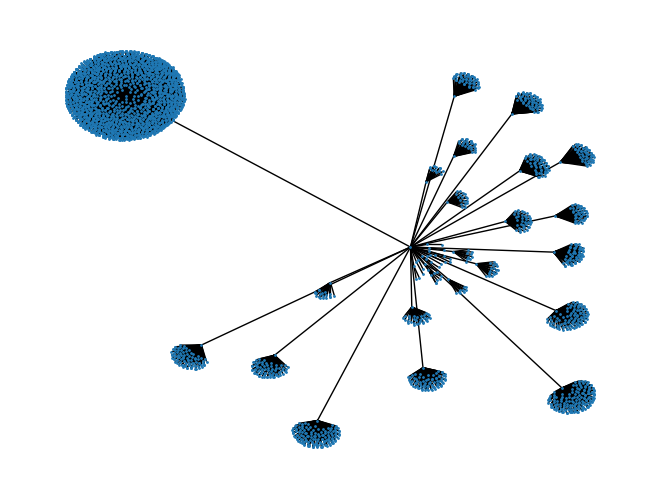

In [26]:
# draw the graph
nx.draw(G, node_size=1)
plt.show()

100%|██████████| 3337/3337 [00:04<00:00, 805.90it/s]


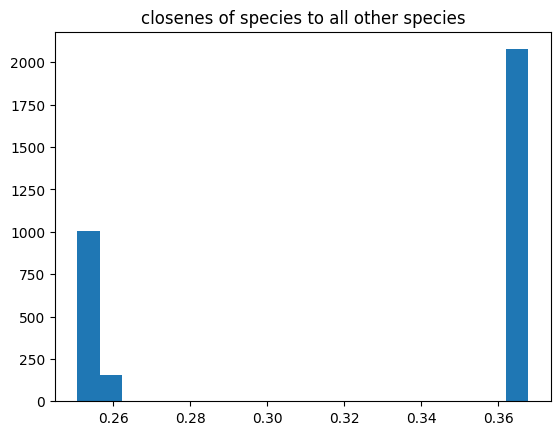

0.3270213314731551

In [60]:
G = generate_ebird_graph(ebird_df, set(mapped_labels))
centrality = []
for node in tqdm.tqdm(mapped_labels):
    try:
        centrality.append(nx.closeness_centrality(G, node))
    except:
        continue

plt.title("closenes of species to all other species")
plt.hist(centrality, bins=20)
plt.show()
np.mean(centrality)

## closeness of birdclef 2023

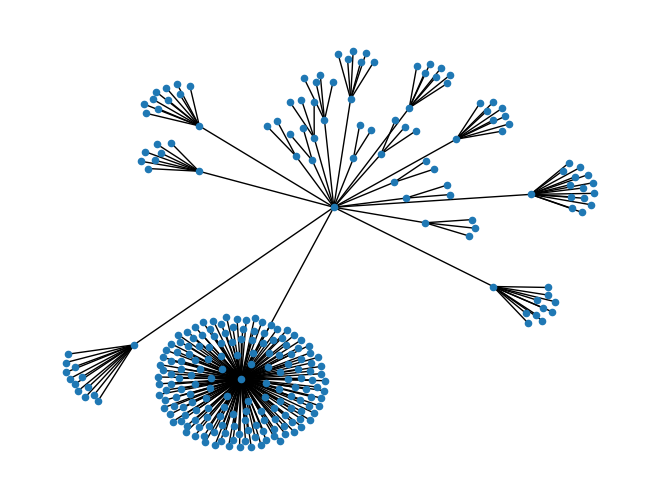

In [55]:
species = [p.name for p in Path("../data/raw/birdclef-2023/train_audio").glob("*")]
# plot the graph
G = generate_ebird_graph(ebird_df, set(species))
nx.draw(G, node_size=20)
plt.show()

100%|██████████| 264/264 [00:05<00:00, 49.42it/s]


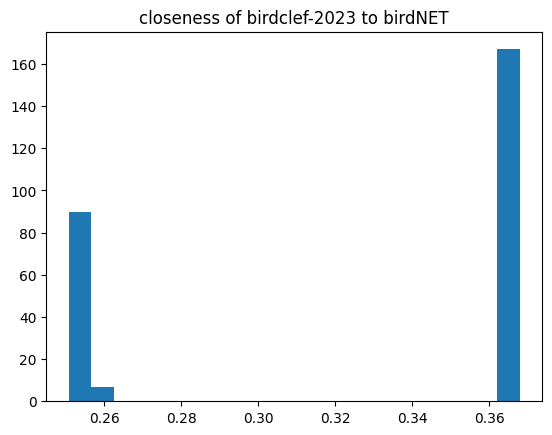

0.32573688152076563

In [58]:
centrality = []
for specie in tqdm.tqdm(species):
    G = generate_ebird_graph(ebird_df, set(mapped_labels) | set([specie]))
    try:
        centrality.append(nx.closeness_centrality(G, specie))
    except:
        continue

plt.title("closeness of birdclef-2023 to birdNET")
plt.hist(centrality, bins=20)
plt.show()
np.mean(centrality)

## closeness of birdclef 2022

The average [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) is smaller than the the 2023 dataset. Lower number means that the species is more distant from the rest of the taxonomy tree.

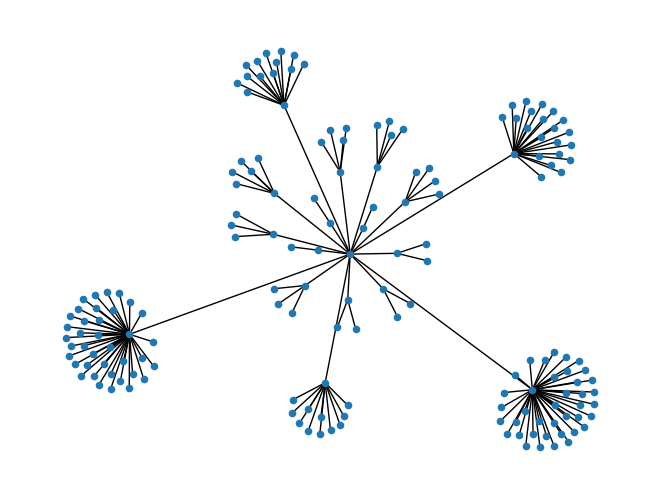

In [61]:
species = [p.name for p in Path("../data/raw/birdclef-2022/train_audio").glob("*")]
# plot the graph
G = generate_ebird_graph(ebird_df, set(species))
nx.draw(G, node_size=20)
plt.show()

100%|██████████| 152/152 [00:02<00:00, 50.84it/s]


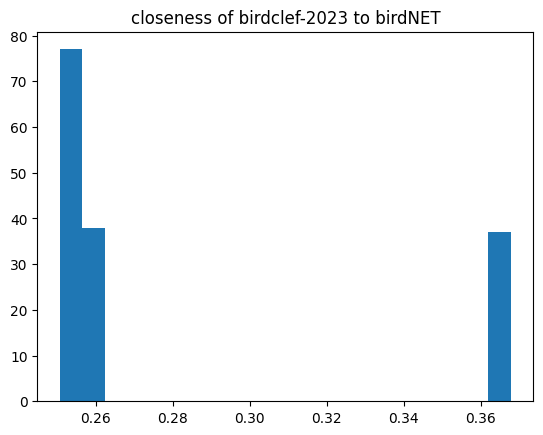

0.28176507373837095

In [62]:
centrality = []
for specie in tqdm.tqdm(species):
    G = generate_ebird_graph(ebird_df, set(mapped_labels) | set([specie]))
    try:
        centrality.append(nx.closeness_centrality(G, specie))
    except:
        continue

plt.title("closeness of birdclef-2023 to birdNET")
plt.hist(centrality, bins=20)
plt.show()
np.mean(centrality)